# Data Storytelling

Our target variable that we will eventually look to predict is 'logerror' for our dataset of housing transactions. Since we are not predicting housing prices directly, we can expect to find different patterns. Additionally, if an observation has a high logerror then Zillow's estimation will have been inaccurate.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
Housing_data = pd.read_csv('cleaned_1.csv')
Housing_data = Housing_data.set_index(['parcelid','Unnamed: 1'])
del Housing_data['garagetotalsqft'] # this has a very large amount of missing data, so will be excluded for now
Housing_data['transactiondate'] = pd.to_datetime(Housing_data['transactiondate'], format = '%Y-%m-%d', errors = 'coerce')
Housing_data['yearbuilt'] = pd.to_datetime(Housing_data['yearbuilt'], format='%Y.0', errors='coerce').dt.year
Housing_data['assessmentyear'] = pd.to_datetime(Housing_data['assessmentyear'], format='%Y-%m-%d', errors='coerce').dt.year
Housing_data['taxdelinquencyyear'] = pd.to_datetime(Housing_data['taxdelinquencyyear'], format='%Y-%m-%d', errors='coerce').dt.year

Before we begin asking questions we will start by splitting up our variables into 4 categories (not including logerror). And then go through and look very roughly at correllation for the continuous and ordinal variables to see if there are any broad picture patterns.

In [3]:
cont_cols = ['calculatedfinishedsquarefeet','finishedsquarefeet12','latitude','longitude',
            'lotsizesquarefeet','taxvaluedollarcnt','taxamount','poolsizesum','propertyzoningdesc',
             'yardbuildingsqft17','yardbuildingsqft26','rawcensustractandblock','censustractandblock']
ord_cols = ['buildingqualitytypeid','bathroomcnt','bedroomcnt','fullbathcnt','garagecarcnt','roomcnt','unitcnt',
           'fireplacecnt']
cat_cols = ['fips', 'propertycountylandusecode','propertylandusetypeid',
           'regionidcity','regionidneighborhood',
           'regionidzip','decktypeid','pooltypeid']
date_cols = ['yearbuilt','assessmentyear','taxdelinquencyyear','transactiondate']

In [4]:
for col in cont_cols:
    correl = Housing_data[col].corr(Housing_data['logerror'])
    print(col, correl)

calculatedfinishedsquarefeet 0.039710445472550114
finishedsquarefeet12 0.04397711698220087
latitude -0.002724658427012945
longitude 0.005344218087668473
lotsizesquarefeet 0.007826463256075626
taxvaluedollarcnt 0.004297641678440769
taxamount -0.0030998970454090575
poolsizesum -0.004194374232639307
propertyzoningdesc 0.0021703697609910225
yardbuildingsqft17 -0.001952563618264091
yardbuildingsqft26 -0.0017184530094314341
rawcensustractandblock 0.0074358071062552485
censustractandblock 0.004131712764048645


In [5]:
for col in ord_cols:
    correl = Housing_data[col].corr(Housing_data['logerror'])
    print(col, correl)

buildingqualitytypeid -0.010079885220393287
bathroomcnt 0.026265798196627988
bedroomcnt 0.028798345847397815
fullbathcnt 0.024707727295909875
garagecarcnt 0.01088373840968781
roomcnt 0.01000495009091296
unitcnt -0.0062683155528330346
fireplacecnt 0.00509950477901178


### Initial Observations

While there is very little in the way of direct correlation, we notice the closest correlation with 'finishedsquarefeet12' and 'calculatedfinishedsquarefeet.' These both measure (more or less) the same thing, so we will begin our analysis with 'finishedsquarefeet12' which measures the square feet of the main building the property (like a house).

We look at first a simple time plot for both the logerror and the square footage over the time period we have. We notice that in the middle of the year, smaller houses are sold and the corresponding logerror is larger. Meanwhile, at the beginning and end of the year larger houses are sold and the logerror is smaller.

We may begin to consider that larger houses are more predictable by Zillow's estimation.

Text(0,0.5,'logerror')

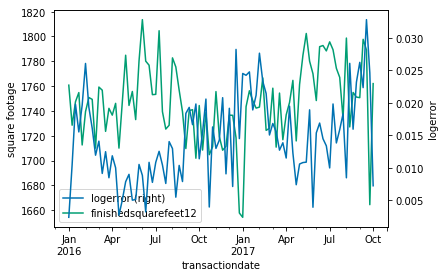

In [6]:
plt.style.use('seaborn-colorblind')
error_df = Housing_data[['logerror','finishedsquarefeet12','transactiondate']].dropna()
error_df = error_df.set_index('transactiondate').copy()
error_df.sort_index(inplace=True)
error_df = error_df.resample('W').mean()

ax = error_df.plot(secondary_y=['logerror'])
ax.set_ylabel('square footage')
ax.right_ax.set_ylabel('logerror')

### First Observations

We will put together a combination scatterplot/histogram. The main part of the plot is a scatter plot comparing the square footage of an observation to it's recorded logerror. The other two will be histograms looking at the distribution of the logerror and squarefeet.

We will also include the highest correlative variable from the ordinals (bedroom count) as a colour variable in the plot

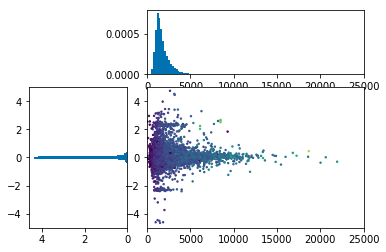

In [13]:
plt.figure()
gspec = gridspec.GridSpec(3, 3)

top_histogram = plt.subplot(gspec[0, 1:])
side_histogram = plt.subplot(gspec[1:, 0])
lower_right = plt.subplot(gspec[1:, 1:])

space_df = Housing_data[['finishedsquarefeet12','bedroomcnt','logerror']].dropna()

lower_right.scatter(space_df['finishedsquarefeet12'],space_df['logerror'],
                   c = space_df['bedroomcnt'], s = 2, cmap = 'viridis')
top_histogram.clear()
top_histogram.hist(space_df['finishedsquarefeet12'], bins=100, density = 'normal')
side_histogram.clear()
side_histogram.hist(space_df['logerror'], bins=100, orientation='horizontal', density = 'normal')
side_histogram.invert_xaxis()

for ax in [top_histogram, lower_right]:
    ax.set_xlim(0, 25000)
for ax in [side_histogram, lower_right]:
    ax.set_ylim(-5, 5)

Some initial observations are that, in spite of the variety of the scatterplot, the vast majority of observations score a very low logerror. As such, we will want to focus of those observations which are less accurate, with logerror values greater than 0.5 in absolute value. Additionally almost all observations are smaller than 5000 sqft.

The histogram tells us that the observations larger than 10000 sqft tend to also be quite accurate with low logerrors. This confirms our initial guesses based on the time plots. We thus only use those houses smaller than 10000 sqft

Perhaps most intriguing is the two clusters of observations whose logerror is around 2.1 and -2.1 (these clusters persist in other variables as well, this is done in some rough work in the Data_exploration rough work notebook). We will look more closely into those by repeating the above graphic but with dropping the larger properties and colouring the points based on their square footage.

Our next step will be to look at this scatter plot but go through a number of different variables to colour the dots to see if we can find out which variable may be having the effect of giving those specific logerror values of 2.1 and -2.1.

First we look specifically at the year the house was built.

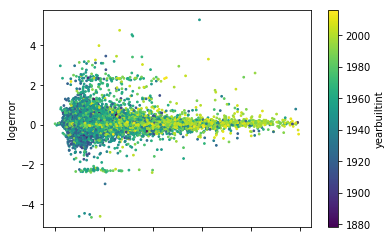

In [14]:
smallhousedf = Housing_data.drop(['taxdelinquencyyear'], axis = 1)
smallhousedf = smallhousedf.dropna()
smallhousedf=smallhousedf[smallhousedf['finishedsquarefeet12'] <= 10000]

smallhousedf['yearbuiltint'] = smallhousedf['yearbuilt'].astype(int)
smallhousedf.plot.scatter('finishedsquarefeet12', 'logerror', c='yearbuiltint', s=3,
                           colormap='viridis')

## Going through ordinal variables

We can see in the above plot that house built before 1950 and very new houses are less likely to be in those two clusters, but we will look for other variables now.

/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


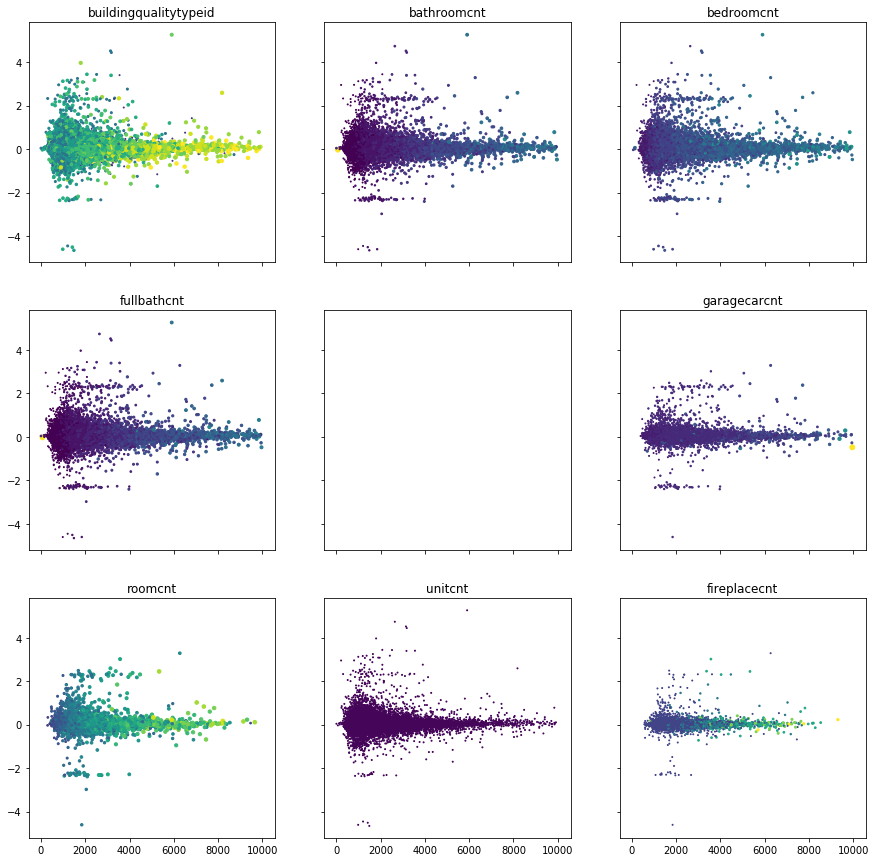

In [17]:
# create a 3x3 grid of subplots
fig, ((ax1,ax2,ax3), (ax4,ax9,ax5), (ax6,ax7,ax8)) = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))
# plot the linear_data on the 5th subplot axes 

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for n in range(0, len(axs)):
    axs[n].scatter(smallhousedf['finishedsquarefeet12'],smallhousedf['logerror'], 
                    c = smallhousedf[ord_cols[n]], s = smallhousedf[ord_cols[n]], cmap = 'viridis')
    axs[n].set_title(ord_cols[n])

## Going through categoricals

The orginal variables look far more tied to the size of the house and we aren't seeing any variable where the two cluserts appear to be coloured differently from the main grouping around 0. Especially with variables like unitcnt in which all see to be the same colour.

So we will now look at the categorical variables.

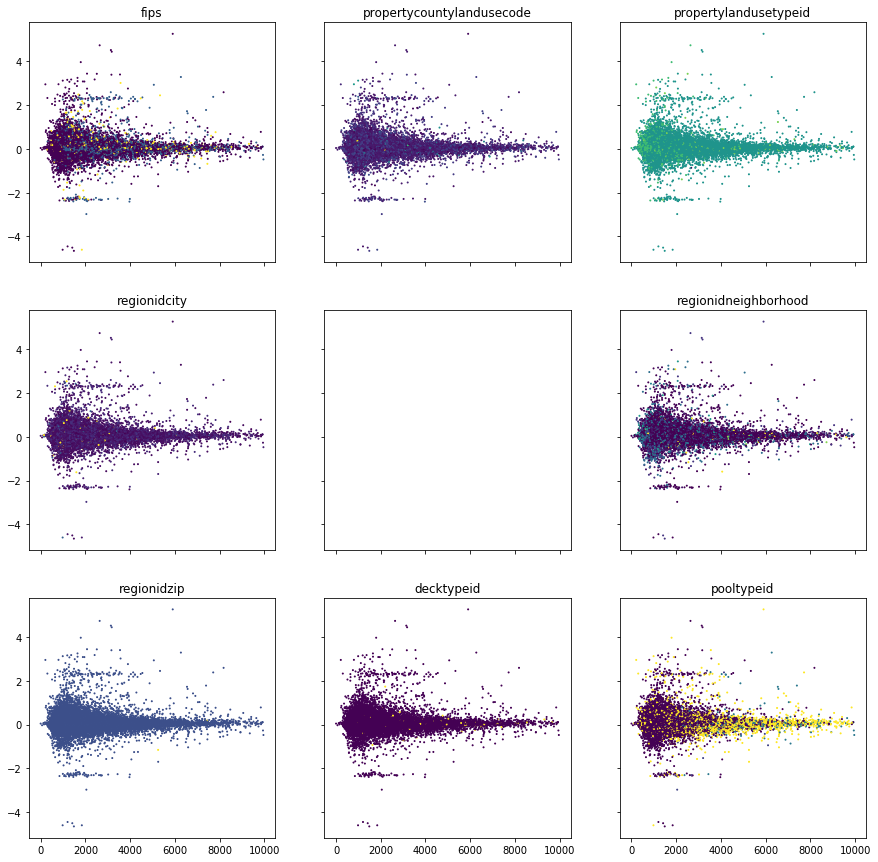

In [18]:
# create a 3x3 grid of subplots
fig, ((bx1,bx2,bx3), (bx4,bx9,bx5), (bx6,bx7,bx8)) = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))
# plot the linear_data on the 5th subplot axes 

bxs = [bx1,bx2,bx3,bx4,bx5,bx6,bx7,bx8]

for n in range(0, len(bxs)):
    bxs[n].scatter(smallhousedf['finishedsquarefeet12'],smallhousedf['logerror'], 
                    c = smallhousedf[cat_cols[n]], s = 1, cmap = 'viridis')
    bxs[n].set_title(cat_cols[n])

Here we notice that fips, regionidcity and pooltypeid have our two clusters coloured slightly differently than the main group. So we will remember these as potentially useful variables in finding those clusers.

## Continuous variables.

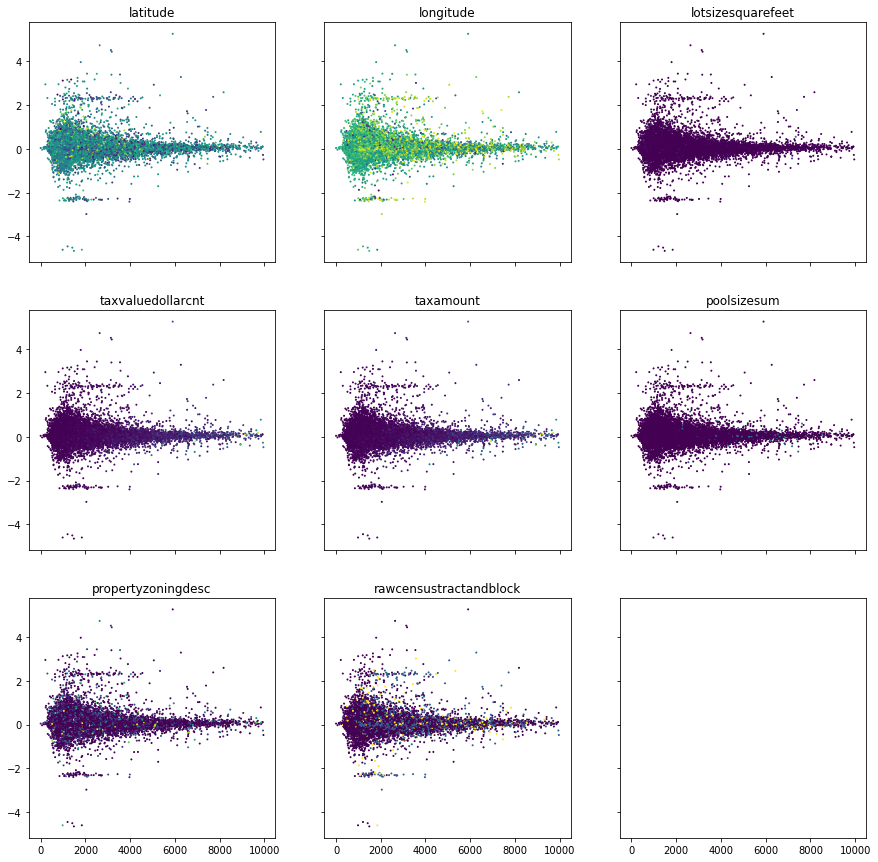

In [19]:
cont_cols_abr = ['latitude','longitude','lotsizesquarefeet','taxvaluedollarcnt',
                 'taxamount','poolsizesum','propertyzoningdesc','rawcensustractandblock','censustractandblock']
fig, ((x1,x2,x3), (x4,x5,x6), (x7,x8,x9)) = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))
# plot the linear_data on the 5th subplot axes 

xs = [x1,x2,x3,x4,x5,x6,x7,x8]

for n in range(0, len(xs)):
    xs[n].scatter(smallhousedf['finishedsquarefeet12'],smallhousedf['logerror'], 
                    c = smallhousedf[cont_cols_abr[n]], s = 1, cmap = 'viridis')
    xs[n].set_title(cont_cols_abr[n])

Here we have a few more variables that seem to identify our two clusters better. The coordinate variables, as well as rawcensustractandblock. A pattern that where the house is might have a factor in whether or not it falls into these clusters might be emerging. There are a handful of other 'forgotten' variables which we will now also look at.

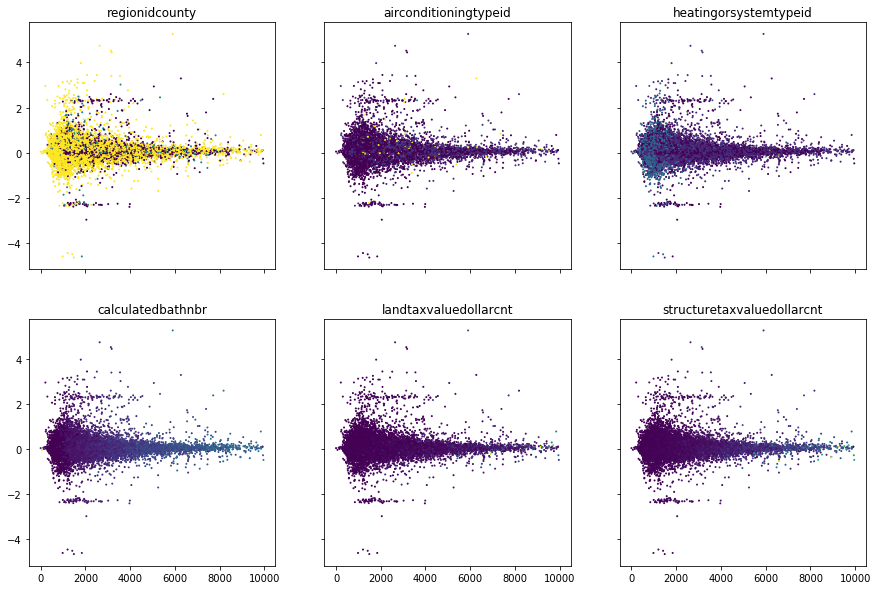

In [22]:
forgotten_cols = ['regionidcounty','airconditioningtypeid','heatingorsystemtypeid','calculatedbathnbr',
                 'landtaxvaluedollarcnt','structuretaxvaluedollarcnt']

# plot the linear_data on the 5th subplot axes 
fig, ((cx1,cx2,cx3), (cx4,cx5,cx6)) = plt.subplots(2,3, sharex=True, sharey=True, figsize=(15,10))
cxs = [cx1,cx2,cx3,cx4,cx5,cx6]

for n in range(0, len(cxs)):
    cxs[n].scatter(smallhousedf['finishedsquarefeet12'],smallhousedf['logerror'], 
                    c = smallhousedf[forgotten_cols[n]], s = 1, cmap = 'viridis')
    cxs[n].set_title(forgotten_cols[n])

regionidcounty also seems to help identify the clusers. So we have some possible location oriented variables that might cause a transaction's logerror to gravitate toward 2.1 in absolute value.

So we have the variables 'fips', 'regionidcity', 'pooltypeid', 'latitude', 'longditude', 'rawcensustrackandblock', and 'regionidcounty' which seem to track closely with those two clusters. But we want to examine a few things to get more information.

The first is why is 'regionidzip' so much different than 'regionidcounty'? We will look at this with the following information.

In [17]:
smallhousedf['regionidzip'].describe()

count    140970.000000
mean      96562.625403
std        3935.406873
min          -1.000000
25%       96193.000000
50%       96378.000000
75%       96979.000000
max      399675.000000
Name: regionidzip, dtype: float64

In [19]:
smalladjust= smallhousedf[(smallhousedf['regionidzip'] > 96000) & (smallhousedf['regionidzip'] < 100000)]
smalladjust['regionidzip'].describe()

count    137871.000000
mean      96528.299243
std         402.033228
min       96001.000000
25%       96206.000000
50%       96383.000000
75%       96982.000000
max       97344.000000
Name: regionidzip, dtype: float64

Here we note that the single colour was due to the replaced null values of -1 and a very small number of very high value of 399675 throwing off the colour scale. When we remove those outliers we get a colour plot which much more closely matches that of regiondidcounty.

<IPython.core.display.Javascript object>


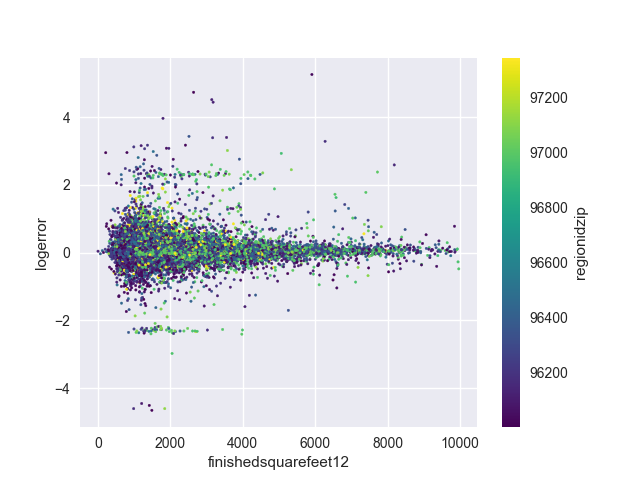

In [20]:
smalladjust.plot.scatter('finishedsquarefeet12', 'logerror', c='regionidzip', s=3,
                           colormap='viridis')

Now we want to look the dataset including the entries whose logerror is higher than 10k, just incase we arent getting any anomolies over there.

In [33]:
interesting_cols_plus = ['fips', 'regionidcity', 'pooltypeid', 'latitude','finishedsquarefeet12', 'logerror',
                    'longitude', 'rawcensustractandblock', 'regionidcounty', 'regionidzip']
interesting_cols = ['fips', 'regionidcity', 'pooltypeid', 'latitude',
                    'longitude', 'rawcensustractandblock', 'regionidcounty', 'regionidzip']

New_df = Housing_data.drop(['taxdelinquencyyear'], axis = 1)
New_df = New_df[interesting_cols_plus].dropna()
New_df = New_df[(New_df['regionidzip'] > 96000) & (New_df['regionidzip'] < 100000)]

<IPython.core.display.Javascript object>


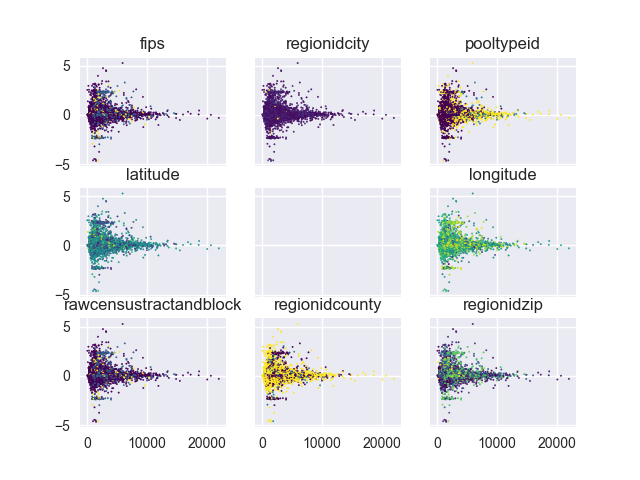

In [34]:
# create a 3x3 grid of subplots
fig, ((ex1,ex2,ex3), (ex4,ex9,ex5), (ex6,ex7,ex8)) = plt.subplots(3, 3, sharex=True, sharey=True)
# plot the linear_data on the 5th subplot axes 

exs = [ex1,ex2,ex3,ex4,ex5,ex6,ex7,ex8]

for n in range(0, len(exs)):
    exs[n].scatter(New_df['finishedsquarefeet12'],New_df['logerror'], 
                    c = New_df[interesting_cols[n]], s = 1, cmap = 'viridis')
    exs[n].set_title(interesting_cols[n])

Here we can note that the inclusion of the 10000+ logerror data points doesnt change anything and we have our 'interesting cols' as the variables which seem to have an effect on the two clusters. Many of these are location oriented.

Going forward, we will look to these largely for trainging models.